<a href="https://colab.research.google.com/github/vdlphm/CS403-Fall-2023/blob/main/hw10/hw10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HW10. Contact Constraint Simulation**

In this problem, you will extend the simulation of HW 9 to address constraints. Your simulation will include a wall that will interact with the robot manipulator. 

<img src="https://github.com/DARoSLab/CS403-Intro-Robotics/blob/main/hws/hw10/3DoF_Arm_contact.png?raw=true" height="400">
<img src="https://github.com/DARoSLab/CS403-Intro-Robotics/blob/main/hws/hw8/3DoF_Arm_Kinematics.png?raw=true" height="400">

In the HW 10, we will use **<font color='orange'>operational-space controller</font>** implemented in HW9: 

\begin{equation}
\Lambda(q)\, \ddot{\mathbf r}_C + \mu(q,\dot{q}) + \rho(q) = F,
\end{equation}

where $\Lambda(q)$ is the effective mass felt at the tip of arm, $\mu(q,\dot{q})$ gives the coriolis and centripetal forces on the tip, and $\rho(q)$ gives the gravity force felt on the tip. Formula for these quantities are given below:

\begin{align}
\Lambda(q)&= (J M^{-1} J^{T})^{-1} \\
\mu(q,\dot{q}) &= \Lambda J M^{-1}\, C - \Lambda \, \dot{J}\, \dot{q}\\
\rho(q) &= \Lambda J M^{-1}\, G
\end{align}

The final joint torque command calculation is done by the following equation:

\begin{equation}
\tau = J^{\top} \left[ \Lambda \left( \ddot{\mathbf r}_C^d + K ({\mathbf r}_C^d - {\mathbf r}_C) + D (\dot{\mathbf r}_C^d - \dot{\mathbf r}_C)\right) + \mu + \rho \right]\,.
\end{equation}


In [48]:
# import useful libraries and clone class github
import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation
import dill
import os
!git clone https://github.com/DARoSLab/CS403-Intro-Robotics
func_path =  '/content/CS403-Intro-Robotics/hws/hw9/functions/'

%matplotlib inline


fatal: destination path 'CS403-Intro-Robotics' already exists and is not an empty directory.


In [49]:
from re import X
# 3 dof arm visualization function: No need to change
def visualize_arm(keypoints_hist, xee_des=None, dt = 0.001, num_frames=200, wall_pos=None):
  fig= plt.figure(figsize=(10,10))
  ax = plt.subplot(1,1,1)
  ax.grid()
  keypoints = keypoints_hist[0]
  link1, = ax.plot([], [], 'r', lw=15, alpha=0.3)
  link2, = ax.plot([], [], 'r', lw=15, alpha=0.3)
  link3, = ax.plot([], [], 'r', lw=15, alpha=0.3)

  if xee_des is not None:
    target, = ax.plot(xee_des[:, 0], xee_des[:, 1], 'o', label='target')
  if wall_pos is not None:
    wall, = ax.plot([wall_pos-0.1, wall_pos-0.1], [-2, 2], lw=30, alpha=0.3, color='black')
  txt_title = ax.set_title('')
  
  ax.set_xlim(( -1.5, 1))            
  ax.set_ylim((-0.5, 2.0))
  txt_title = ax.set_title('')
  interval = len(keypoints_hist)//num_frames
  def drawFrame(k):
    k = interval*k
    keypts = keypoints_hist[k]

    x1 = keypts[0, 0]
    x2 = keypts[1, 0]
    y1 = keypts[0, 1]
    y2 = keypts[1, 1]
    link1.set_data([x1, x2], [y1, y2])
    x1 = keypts[1, 0]
    x2 = keypts[2, 0]
    y1 = keypts[1, 1]
    y2 = keypts[2, 1]
    link2.set_data([x1, x2], [y1, y2])
    x1 = keypts[2, 0]
    x2 = keypts[3, 0]
    y1 = keypts[2, 1]
    y2 = keypts[3, 1]
    link3.set_data([x1, x2], [y1, y2])
    txt_title.set_text(f't = {dt*k:.2f} sec')
    return link1, link2, link3
  anim = animation.FuncAnimation(fig, drawFrame, frames=num_frames, interval=interval, blit=True)
  return anim

# Loading Helper Functions For Simulation

In [50]:
# Loading helper functions: No need to change

# A ddq + coriolis + grav = Q
A_func = dill.load(open(func_path+"A_func", "rb")) # Mass matrix
grav_func = dill.load(open(func_path+"grav_func", "rb")) # gravitational force vector
coriolis_func = dill.load(open(func_path+"coriolis_func", "rb")) # coriolis and centri

# End effector (r_D) position and velocity
pD_func = dill.load(open(func_path+"pD_func", "rb"))
vD_func = dill.load(open(func_path+"vD_func", "rb"))

# End effector (r_D)'s Jacobian and time derivative of the Jacobian
J_func = dill.load(open(func_path+"J_func", "rb"))
Jdot_func = dill.load(open(func_path+"Jdot_func", "rb"))

# key points: Matrix([[rO],[rB],[rC], [rD]]).reshape(4, 3)
keypoints_func = dill.load(open(func_path+"keypoints_func", "rb"))

# Kinetic energy, potential energy, and total energy
kinetic_energy_func = dill.load(open(func_path+"kinetic_energy_func", "rb"))
potential_energy_func = dill.load(open(func_path+"potential_energy_func", "rb"))
E_func = dill.load(open(func_path+"E_func", "rb"))

In [51]:
# parameters: No need to change
m1_p = 1.5
m2_p = 1.
m3_p = 2.0
l1_p = .6
l2_p = .4
l3_p = .5
c1_p = .3
c2_p = .2
c3_p = .4
I1_p = 0.05
I2_p = 0.05
I3_p = 0.09

g_p  = 9.81    
params   = [l1_p, l2_p , l3_p, c1_p, c2_p, c3_p, m1_p, m2_p, m3_p, I1_p, I2_p, I3_p, g_p]

In [52]:
# Simulation parameters: No need to change
dt = 0.001
tf = 3.5
num_step = int(np.floor(tf/dt))
x0 = np.array([np.pi/2 - 0.1, 1.5, -0.9, 0, 0, 0]).T  # Initial configuration
xC=-0.8 # Wall location

# Circular desired trajectory: No need to change 
r0 = [-0.72, 0.9]
r_circle = 0.3
omega = 2*np.pi*0.5
xee_des_circular = np.zeros((num_step, 9))

for i in range(num_step):
  t = i*dt
  xee_des_circular[i, :] = np.array([r0[0] + r_circle*np.cos(omega*t), r0[1] + r_circle*np.sin(omega*t), 3*np.pi/4, # position
                            -omega*r_circle*np.sin(omega*t), omega*r_circle*np.cos(omega*t), 0, # vel
                            -omega*omega*r_circle*np.cos(omega*t), -omega*omega*r_circle*np.sin(omega*t), 0]) # acc

In [53]:
# Operational Space Controller (OSC): No need to change
def OSC_controller(x, params, xee_des, Kp, Kd):
  xp_params = list(x) + list(params)
  J = J_func(*xp_params)
  p_ee  = pD_func(*xp_params)
  v_ee  = vD_func(*xp_params)
  
  e = xee_des[:3] - p_ee.reshape(-1)
  ed = xee_des[3:6] - v_ee.reshape(-1)

  command  = (xee_des[6:] + Kp*e + Kd*ed).reshape(3,1)

  M = A_func(*xp_params)
  grav = grav_func(*xp_params)
  coriolis = coriolis_func(*xp_params)
  Jdot = Jdot_func(*xp_params)

  M_inv = np.linalg.inv(M)
  Lambda_inv = J@M_inv@J.T
  Lambda = np.linalg.inv(Lambda_inv)
  
  qdot = x[3:].reshape(3, 1)
  mu = Lambda@J@M_inv@coriolis - Lambda@Jdot@qdot 

  rho = Lambda@J@M_inv@grav
  
  F = Lambda@command + mu + rho

  u = (J.T@F).reshape(-1).tolist()
  return u

# **Q.1. Spring-damper based contact modeling**

Implement a dynamics simulation including wall without friction (no contact force in the tangential direction of the wall) by using virtual spring-damper based algorithm.

# **Q.1.(a) [20 pts] Simulation including a wall contact constraint**
Complete the simulation program by adding your code computing proper $F_r$ (reaction force). Utilize the following equation:

\begin{equation}
F_{r,x} = K (x_{\rm wall} - x_{ee,x}) - D(\dot{x}_{ee,x}), 
\end{equation}
where $K$ and $D$ are a virtual spring constant and a damping coefficient, respectively. $x_{ee,x}$ and $\dot{x}_{ee,x}$ are the $x$ directional end effector position and velocity, respectively. 

In [54]:
# Simulation with wall contact constraint
def run_simulation_spring_damper_contact(x0, num_step, dt, xee_des_trj, ctrl_function, xC=0.8):
  x_out = np.zeros((6,num_step))
  x_out[:,0] = x0
  ts = np.zeros(num_step)

  keypoints_hist = []
  
  K = 3000
  D = 10


  for i in range(num_step-1):
    xp_params = list(x_out[:, i]) + list(params)
    keypoints_hist.append(keypoints_func(*xp_params))

    u = ctrl_function(x_out[:, i], params, xee_des_trj[i]) 
    Q = np.array(u).reshape(3,1) # Generalized force ([tau1, tau2, tau3])

    A_dyn = A_func(*xp_params)
    cori = coriolis_func(*xp_params)
    grav = grav_func(*xp_params)
    
    Fr = np.zeros([1,1]) # Reaction force to x (normal) direction
    J = J_func(*xp_params)
    Jx = J[0,:].reshape(1,3) # Jacobian conincide to the normal direction
    # Write your code: Complete the code to compute Fr
    # vee = xee_des_trj[i, 3]
    # dist = xC - xee_des_trj[i, 0]
    ree = pD_func(*xp_params)
    vee = vD_func(*xp_params)
    dist = xC - ree[0]
    if vee[0] < 0 and dist > 0:
      Fr[0,0] = K * (dist) - D * vee[0]

    # Semi-implicit Euler integration: No need to change
    ddq = np.linalg.pinv(A_dyn)@(Q - cori - grav + Jx.T@Fr)
    x_out[3:, i+1] = x_out[3:,i] + ddq.reshape(3)*dt
    x_out[:3, i+1] = x_out[:3,i] + x_out[3:,i+1]*dt  

    ts[i+1] = ts[i] + dt 

  return ts, x_out, keypoints_hist

In [55]:
# Run simulation: No need to change
ctrl_func = lambda x, params, xee_des: OSC_controller(x, params, xee_des, Kp = 200, Kd = 10)
[ts, x_out_spring, key_pts_spring] = run_simulation_spring_damper_contact(x0, num_step, dt, xee_des_circular, ctrl_func, xC = xC)

In [ ]:
# Animation: No need to change 
anim = visualize_arm(key_pts_spring, xee_des=xee_des_circular, dt = dt, num_frames=200, wall_pos=xC)
plt.close()
HTML(anim.to_html5_video())

# **Q.1.(b) [10 pts] Plot and analyze the results**

Complete the following code for trajectory plot. Explain your result based on the spring constant and damping coefficient. Note: Depending on spring and damping parameters, your result can be different from the solution. (Solution uses $K = 3000$ and $D = 10$)

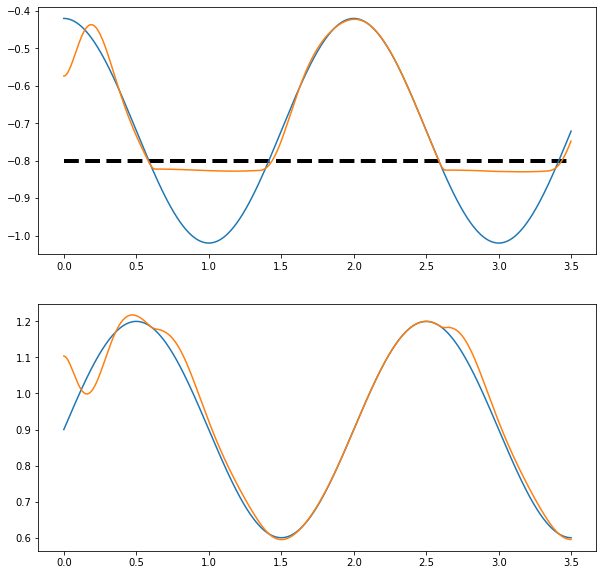

In [56]:
# Write your code: Plot x, y of the tip
fig= plt.figure(figsize=(10,10))
keypoints_spring = np.array(key_pts_spring)

ax = plt.subplot(2,1,1) 
ax.plot([ts[0], ts[-1]], [xC, xC], 'k--', lw=4, label='contact x pos') 
ax.plot(ts, xee_des_circular[:, 0], label='x des')
ax.plot(ts[:-1], keypoints_spring[:, 3, 0], label='x pos')
ax.legend()

ax = plt.subplot(2,1,2)   
ax.plot(ts, xee_des_circular[:, 1], label='y des')
ax.plot(ts[:-1], keypoints_spring[:, 3, 1], label='y pos')
ax.legend()

plt.show()

# **Q.2. Discret impact based contact simulation (Projected Gauss-Seidel Method)**

Complete skeleton the code for the function discrete_impact_contact and discuss the results. 

*Tip: Implement the normal directional contact first and then move on the tangential directional contact implementation. 

In [57]:
# Dynamics: No need to change
def dynamics(x, params, xee_des, control_func=None):
  xp_params = list(x) + list(params)
  u = control_func(x, params, xee_des) 
  Q = np.array(u).reshape(3,1) # Generalized force ([tau1, tau2, tau3])

  A_dyn = A_func(*xp_params)
  cori = coriolis_func(*xp_params)
  grav = grav_func(*xp_params)
  
  ddq = np.linalg.pinv(A_dyn)@(Q - cori - grav)

  return ddq.reshape(3)

In [58]:
# Simulation: No need to change
def run_simulation(x0, num_step, dt, xee_des_trj, ctrl_function, restitution_coeff=0, friction_coeff=0.3, xC=0.8, q1_max=None):
  x_out = np.zeros((6,num_step))
  x_out[:,0] = x0
  ts = np.zeros(num_step)

  keypoints_hist = []
  kinetic_energy_hist = []
  potential_energy_hist = []
  total_energy_hist = []

  for i in range(num_step-1):
    xp_params = list(x_out[:, i]) + list(params)
    keypoints_hist.append(keypoints_func(*xp_params))
    kinetic_energy_hist.append(kinetic_energy_func(*xp_params))
    potential_energy_hist.append(potential_energy_func(*xp_params))
    total_energy_hist.append(E_func(*xp_params))

    ddq = dynamics(x_out[:,i], params, xee_des_trj[i], control_func = ctrl_function)
    x_out[3:, i+1] = x_out[3:,i] + ddq*dt
    x = np.zeros(6)
    x[:3] = x_out[:3, i]
    x[3:] = x_out[3:, i+1]

    if q1_max is not None:
      x_out[3:, i+1] = joint_limit_constraint(x, params, q1_max) 
    if xC is not None:  
      x_out[3:, i+1] = discrete_impact_contact(x, params, restitution_coeff, friction_coeff, xC)
    
    x_out[:3, i+1] = x_out[:3,i] + x_out[3:,i+1]*dt  

    ts[i+1] = ts[i] + dt 

  return ts, x_out, keypoints_hist, kinetic_energy_hist, potential_energy_hist, total_energy_hist

# **Q.2.(a) [25 pts] Implement normal ($x$) directional contact constraint**

* Compute the position and velocity of the end-effector relative to the wall $C_x = x-x_c$ and $\dot{C}_x$.

* If the constraints are violated (i.e. $C_x<0$ and $\dot{C}_x<0$), compute the normal directional ($x$ direction in this problem) impulse force, $\Delta\hat{F}_{c, x} = \Lambda_{c, x} (-\gamma \dot{C}_x - J_{c, x} \dot{q})$. Here, $\Lambda_{c,x}$ is the normal directional operational space mass, $(J_{c,x} M^{-1} J_{c,x}^{\top})^{-1}$. $\gamma$ is the coefficient of restitution and $J_{c,x}$ is the normal directional Jacobian at the contact point.

* Check whether the total reaction force ($\hat{F}_{c,x}^{\rm temp} = \hat{F}_{c,x}^{\rm prev} + \Delta\hat{F}_{c, x}$) is positive

* If the sum is negative, update $\Delta\hat{F}_{c, x} = 0 - \hat{F}_{c,x}^{\rm prev}$. 

* Update $\dot{q}$ using the equation, $\dot{q} = \dot{q} + M^{-1}J_{c,x}^{\top} \Delta\hat{F}_{c,x}$. 

* Update $\hat{F}_{c,x} = \hat{F}_{c,x}^{\rm prev} + \Delta \hat{F}_{c,x}$.

* Iterate the process until it converges. (e.g., $\Delta \hat{F}_{c,x}$ becomes small)

# **Q.2.(b) [25 pts] Implement tangential ($y$) directional contact constraint**

* Using the same procedure, update $\dot{q}$ by applying tragential impulse force to satisfy a friction cone constraint. Compute the tangential ($y$ in this problem) impulse force, $\Delta\hat{F}_{c,y} = \Lambda_{c,y} (0 - J_{c,y} \dot{q})$.

* Check whether the total tangential reaction force ($\hat{F}_{c,y}^{\rm temp} = \hat{F}_{c,y}^{\rm prev} + \Delta\hat{F}_{c, y}$) satisfies the friction cone constraint, $-\mu \hat{F}_{c,x} \leq \hat{F}_{c,y}^{\rm temp} \leq \mu \hat{F}_{c,x}$. 

* Truncate $\hat{F}_{c,y}^{\rm temp}$ if it is outside of friction cone and update $\hat{F}_{c,y}$. Use the equation, $\hat{F}_{c,y} = \max \left(-\mu \hat{F}_{c,x}, \min(\hat{F}_{c,y}^{\rm temp}, \mu \hat{F}_{c,x} ) \right)$. 

* Update $\Delta \hat{F}_{c,y} = \hat{F}_{c,y} - \hat{F}_{c,y}^{\rm prev}$.

* Update $\dot{q}$ using the equation, $\dot{q} = \dot{q} + M^{-1}J_{c,y}^{\top} \Delta\hat{F}_{c,y}$.

* Iterate the process until it converges. 

In [89]:
def discrete_impact_contact(x, p, rest_coeff, fric_coeff, xC):
    print(xC)
    xp_params = list(x) + list(params)

    x_test = x.copy()
    qdot = x[3:].copy()

    # EE position and velocity
    rEE = pD_func(*xp_params) 
    vEE = vD_func(*xp_params)

    if((rEE[0]-xC) < 0 and vEE[0] < 0):
      J  = J_func(*xp_params)
      A = A_func(*xp_params)
      Ainv = np.linalg.inv(A)
      
      J_x = J[0, :]
      J_y = J[1, :]
      lambda_x = 1/(J_x @ Ainv @ J_x.T)
      lambda_y = 1/(J_y @ Ainv @ J_y.T)

      post_impact_vel = np.zeros([2,1])
      post_impact_vel[0] = -rest_coeff*vEE[0]

      Fx_total = 0
      Fy_total = 0
      Fx_inc = 1000
      Fy_inc = 1000

      iter = 0
      
      # Write your code: complete the Projected Gauss-Seidel method
      while(np.abs(Fx_inc) > 1e-2 and np.abs(Fy_inc) > 1e-2):

        # Fx_prev = Fx_total before add
        # Fx_total = Fx_total + FX_inc
        # Fx_inc = Fx_delta

        # Write your code: horizontal (x) - Q2.(a)
        dist = rEE[0] - xC
        if dist < 0 and vEE[0] < 0:
          Fx_inc = lambda_x * (-rest_coeff * vEE[0] - J_x[0] * vEE[2]) # check again here
          if Fx_total + Fx_inc < 0:
            Fx_inc = -Fx_inc
          vEE[2] = vEE[2] + (Ainv @ J_x.T)[0] * Fx_inc
          Fx_total = Fx_total + Fx_inc

        # Write your code: vertical (y) - Q2.(b)
        # if dist < 0 and vEE[0] < 0:
        #   Fy_inc = lambda_y * (0 - J_y[0] * vEE[2])
        #   Fy_temp = Fy_total + Fy_inc
        #   F_fric = fric_coeff * Fy_total
        #   Fy_prev = Fy_total
        #   if -F_fric >= Fy_temp or F_fric <= Fy_temp:
        #     Fy_total = max(-F_fric, min(Fy_temp, F_fric))
        #   Fy_inc = Fy_total - Fy_prev
        #   vEE[2] = vEE[2] + (Ainv @ J_y.T)[2] * Fy_inc


        iter += 1
        if(iter > 10):
          break
        # print(iter)

    return qdot

# **Q.2.(c)[20 pts] Run simulation using different friction coefficients** 

Use the coefficient of resitution $\gamma = 0$, and test three different friction coefficients $\mu = 0.5, 3, 15$. Provide position and velocity plots of $x$ and $y$. Analyze your results. 

In [ ]:
# Run simulation: No need to change
ctrl_func = lambda x, params, xee_des: OSC_controller(x, params, xee_des, Kp = 200, Kd = 10)
[ts, x_out_osc_1, key_pts_osc_1, _, _, _] = run_simulation(x0, num_step, dt, xee_des_circular, ctrl_func, 0.0, 0.5, xC, None)
# [ts, x_out_osc_2, key_pts_osc_2, _, _, _] = run_simulation(x0, num_step, dt, xee_des_circular, ctrl_func, 0.0, 3, xC, None)
# [ts, x_out_osc_3, key_pts_osc_3, _, _, _] = run_simulation(x0, num_step, dt, xee_des_circular, ctrl_func, 0.0, 15, xC, None)

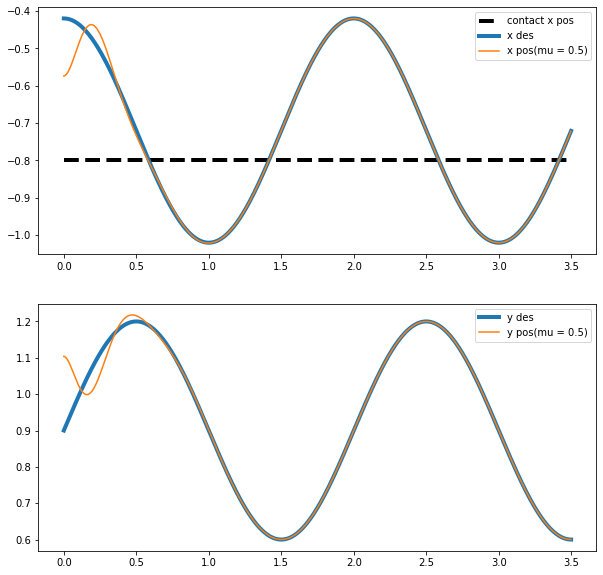

In [91]:
fig= plt.figure(figsize=(10,10))
keypoints_osc_1 = np.array(key_pts_osc_1)
# keypoints_osc_2 = np.array(key_pts_osc_2)
# keypoints_osc_3 = np.array(key_pts_osc_3)

# Write your code: Plot x, y of the tip
ax = plt.subplot(2,1,1) 
ax.plot([ts[0], ts[-1]], [xC, xC], 'k--', lw=4, label='contact x pos') 
ax.plot(ts, xee_des_circular[:,0], label='x des', linewidth = 4)
ax.plot(ts[:-1], keypoints_osc_1[:, 3, 0], label='x pos(mu = 0.5)')
# ax.plot(ts[:-1], keypoints_osc_2[:, 3, 0], label='x pos(mu = 3)')
# ax.plot(ts[:-1], keypoints_osc_3[:, 3, 0], label='x pos(mu = 15)')
ax.legend()

ax = plt.subplot(2,1,2)   
ax.plot(ts, xee_des_circular[:,1], label='y des', linewidth = 4)
ax.plot(ts[:-1], keypoints_osc_1[:, 3, 1], label='y pos(mu = 0.5)')
# ax.plot(ts[:-1], keypoints_osc_2[:, 3, 1], label='y pos(mu = 3)')
# ax.plot(ts[:-1], keypoints_osc_3[:, 3, 1], label='y pos(mu = 15)')
ax.legend()

plt.show()

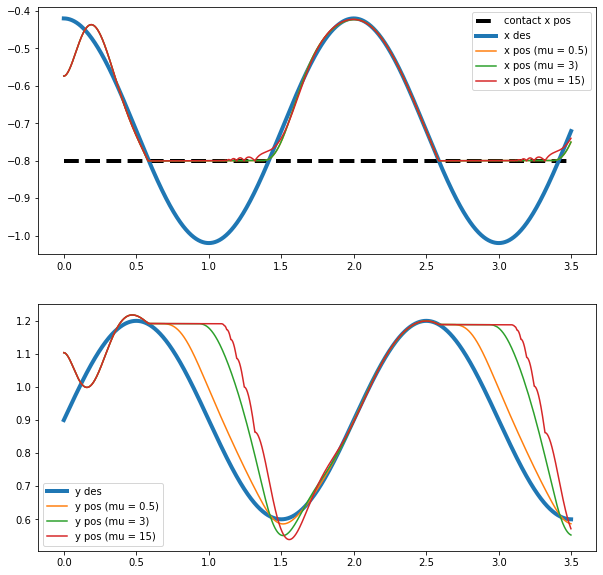

In [ ]:
fig= plt.figure(figsize=(10,10))
keypoints_osc_1 = np.array(key_pts_osc_1)
keypoints_osc_2 = np.array(key_pts_osc_2)
keypoints_osc_3 = np.array(key_pts_osc_3)

# Write your code: Plot x, y of the tip
ax = plt.subplot(2,1,1) 
ax.plot([ts[0], ts[-1]], [xC, xC], 'k--', lw=4, label='contact x pos') 
ax.plot(ts, xee_des_circular[:,0], label='x des', linewidth = 4)
ax.plot(ts, keypoints_osc_1[:, 3, 0], label='x pos(mu = 0.5)', lw=4)
ax.plot(ts, keypoints_osc_2[:, 3, 0], label='x pos(mu = 3)', lw=4)
ax.plot(ts, keypoints_osc_3[:, 3, 0], label='x pos(mu = 15)', lw=4)

ax = plt.subplot(2,1,2)   
ax.plot(ts, xee_des_circular[:,1], label='y des', linewidth = 4)
ax.plot(ts, keypoints_osc_1[:, 3, 1], label='y pos(mu = 0.5)', lw=4)
ax.plot(ts, keypoints_osc_2[:, 3, 1], label='y pos(mu = 3)', lw=4)
ax.plot(ts, keypoints_osc_3[:, 3, 1], label='y pos(mu = 15)', lw=4)

plt.show()

In [88]:
# Animation: No need to change 
anim = visualize_arm(key_pts_osc_1, xee_des=xee_des_circular, dt = dt, num_frames=200, wall_pos=xC)
plt.close()
HTML(anim.to_html5_video())

In [ ]:
# Animation: No need to change 
anim = visualize_arm(key_pts_osc_1, xee_des=xee_des_circular, dt = dt, num_frames=200, wall_pos=xC)
plt.close()
HTML(anim.to_html5_video())

In [ ]:
# Animation: No need to change 
anim = visualize_arm(key_pts_osc_3, xee_des=xee_des_circular, dt = dt, num_frames=200, wall_pos=xC)
plt.close()
HTML(anim.to_html5_video())

# **(Optional) [20 pts] Joint limit constrain** 

The method for enforcing constraints is general to cases beyond contact with the ground. For instance, in reality, this mechanism has a kinematic joint limit that constrains $q_1$. In your code, implement a joint limit constraint to enforce $q_1 < \frac{\pi}{2}$ rad and plot $q_{1, 2, 3}$ over time with the joint constraint.

In [ ]:
def joint_limit_constraint(x,params, q1_max):
    xp_params = list(x) + list(params)
    C = x[0] - q1_max # C gives distance away from constraint
    dC= x[3]
    qdot = x[3:].copy()
    J = np.array([1, 0, 0])

    A = A_func(*xp_params)
    Ainv = np.linalg.inv(A)

    # Write your code: Joint position constraint
    ...
     
    return qdot 

In [ ]:
# Run simulation: No need to change
q1_max = np.pi/2
ctrl_func = lambda x, params, xee_des: OSC_controller(x, params, xee_des, Kp = 50, Kd = 10)
[ts, x_out_osc_jlim, key_pts_osc_jlim, _, _, _] = run_simulation(x0, num_step, dt, xee_des_circular, ctrl_func, 0, 0, xC=None, q1_max=q1_max)

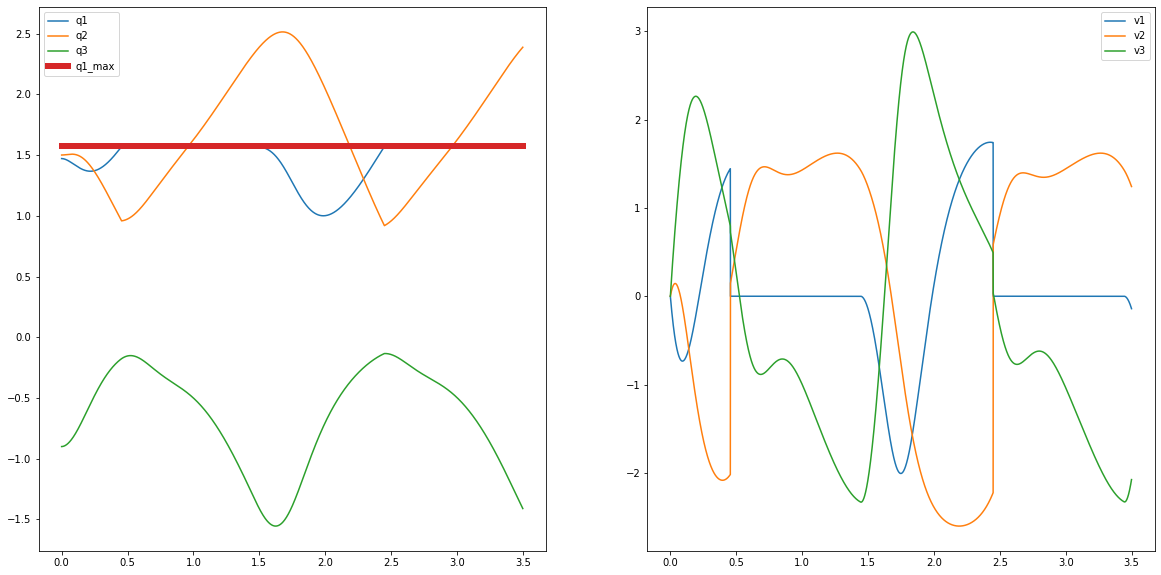

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(20,10))
for i in range(3):
  axs[0].plot(ts, x_out_osc_jlim[i, :], label=f'q{i+1}')
  axs[1].plot(ts, x_out_osc_jlim[3+i, :], label=f'v{i+1}')
axs[0].plot([ts[0], ts[-1]], [q1_max, q1_max], lw=6, label='q1_max') 
axs[0].legend()
axs[1].legend()

plt.show()

In [ ]:
# Animation 
anim = visualize_arm(key_pts_osc_jlim, xee_des=xee_des_circular, dt = dt, num_frames=200, wall_pos=None)
plt.close()
HTML(anim.to_html5_video())